In [2]:
import os
import subprocess
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.functions import explode, col, count, from_unixtime, floor, date_format, hour
from pyspark.sql.types import *
from pyspark.sql.functions import sum as spark_sum

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
gcs_folder = 'gs://msca-bdp-data-open/final_project_git'

## Data Cleaning Functions

In [5]:
def null_count(df):
    return df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) 
     for c in df.columns
    ]).show(truncate=False)

In [6]:
def show_duplicates(df):
    df.groupBy(*df.columns) \
    .agg(count("*").alias("duplicate_count")) \
    .filter(col("duplicate_count") > 1) \
    .show(truncate=False)

# Liscenses Data

In [7]:
df_licenses = spark.read.parquet(os.path.join(gcs_folder, 'licenses'))
print(f'Records read from dataframe *licenses*: {df_licenses.count():,.0f}')
df_licenses.printSchema()

Records read from dataframe *licenses*: 3,325,634
root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)



In [8]:
# Taking a sample of the data
sample_df_licenses = df_licenses.sample(fraction = 0.01, seed = 42)
sample_df_licenses.show(5)

+--------------------+------------+
|           repo_name|     license|
+--------------------+------------+
|      spenk/DrugsMod|artistic-2.0|
|teodozjan/pekao-c...|artistic-2.0|
|gitpan/GappX-File...|artistic-2.0|
|       Tongi/Goliath|artistic-2.0|
|jonathanstowe/p6-...|artistic-2.0|
+--------------------+------------+
only showing top 5 rows



In [9]:
# Missing Values
null_count(sample_df_licenses)

+---------+-------+
|repo_name|license|
+---------+-------+
|0        |0      |
+---------+-------+



In [10]:
# Duplicate values
show_duplicates(sample_df_licenses)

+---------+-------+---------------+
|repo_name|license|duplicate_count|
+---------+-------+---------------+
+---------+-------+---------------+



### Most popular licenses by number of repository 

Repository Counts by License:
+------------+----------------+
|     license|repository_count|
+------------+----------------+
|         mit|           17090|
|  apache-2.0|            5044|
|     gpl-3.0|            3449|
|     gpl-2.0|            3333|
|bsd-3-clause|            1544|
|bsd-2-clause|             546|
|   unlicense|             488|
|    agpl-3.0|             411|
|    lgpl-3.0|             391|
|     epl-1.0|             275|
|     cc0-1.0|             270|
|    lgpl-2.1|             216|
|     mpl-2.0|             182|
|         isc|             173|
|artistic-2.0|              92|
+------------+----------------+



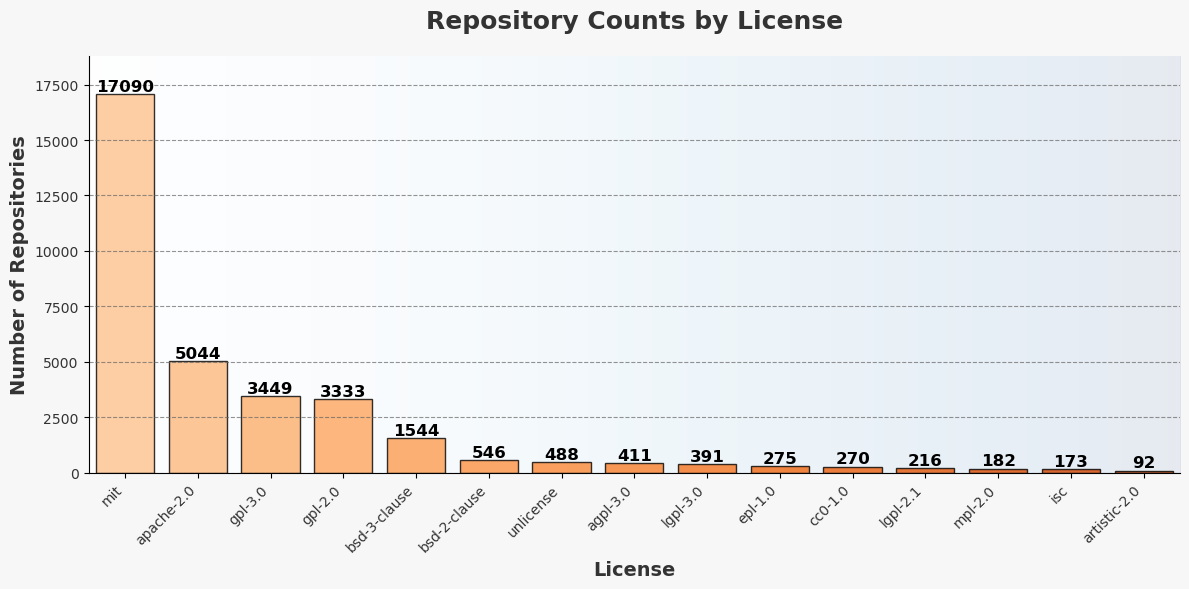

In [11]:
# Step 1: Group by license and count the number of repositories per license
df_license_distribution = (
    sample_df_licenses
    .groupBy("license")
    .agg(F.count("*").alias("repository_count"))
    .orderBy(F.col("repository_count"), ascending=False)
)

# Step 2: Display the counts
print("Repository Counts by License:")
df_license_distribution.show()

# Step 3: Convert the result to a Pandas DataFrame for plotting
license_distribution_pd = df_license_distribution.toPandas()

# Step 4: Plot the repository counts by license with a modern design
plt.figure(figsize=(12, 6), facecolor="#f7f7f7")  # Light gray background

# Add a gradient background
ax = plt.gca()
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect="auto", cmap="Blues", alpha=0.1, extent=(-0.5, len(license_distribution_pd) - 0.5, 0, license_distribution_pd["repository_count"].max() * 1.1))

# Create a gradient color palette for the bars using the Oranges colormap
colors = plt.cm.Oranges(np.linspace(0.3, 0.8, len(license_distribution_pd)))  # Oranges colormap

# Customize the bar plot
bars = plt.bar(license_distribution_pd["license"], license_distribution_pd["repository_count"], color=colors, edgecolor="black", alpha=0.8)

# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}", ha="center", va="bottom", fontsize=12, color="black", fontweight="bold")

# Add title and labels
plt.title("Repository Counts by License", fontsize=18, pad=20, color="#333333", fontweight="bold")
plt.xlabel("License", fontsize=14, color="#333333", fontweight="bold")
plt.ylabel("Number of Repositories", fontsize=14, color="#333333", fontweight="bold")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right", color="#333333")
plt.yticks(color="#333333")

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7, color="#666666")

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()